In [1]:
# ✅ Install any missing libraries (run once)
!pip install xgboost gradio

# ✅ Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import files
uploaded = files.upload()  # Choose Resume.csv from your computer

import pandas as pd
df = pd.read_csv('/content/Resume.csv')

Saving Resume.csv to Resume.csv


In [3]:
import pandas as pd
df = pd.read_csv('/content/Resume.csv')


In [4]:
display(df.head())
df.info()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [5]:
# ✅ Drop unnecessary columns safely
df = df.drop(columns=['ID', 'Resume_html'], errors='ignore')


In [6]:
display(df.head())


,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


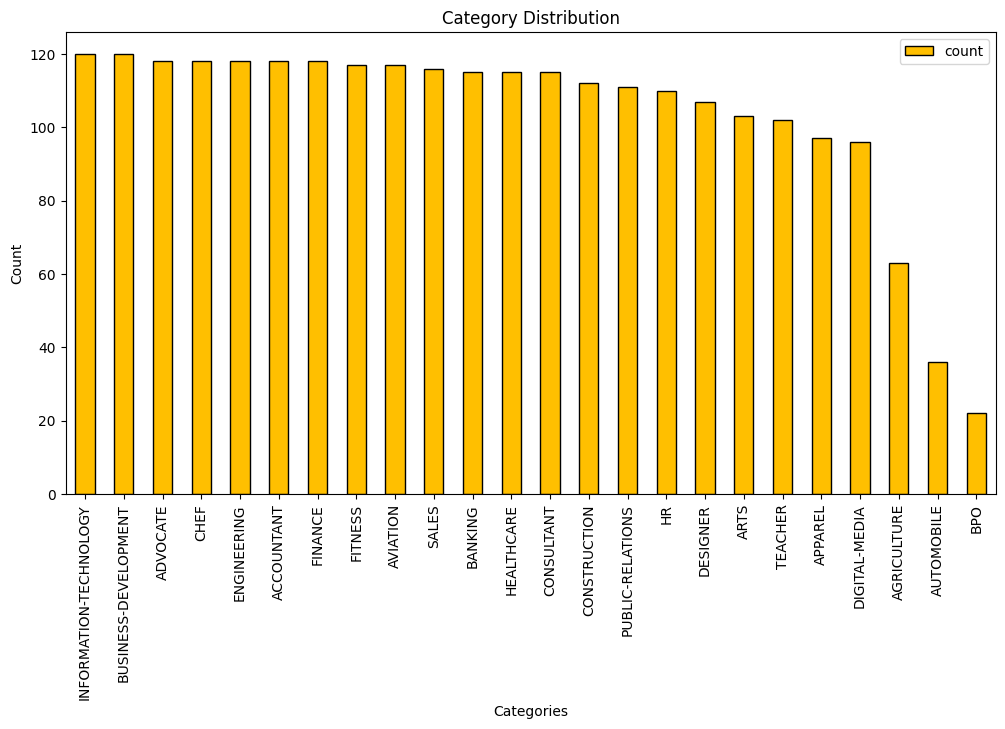

In [7]:
import matplotlib.pyplot as plt

df["Category"].value_counts().plot(
    kind="bar",
    figsize=(12,6),
    title="Category Distribution",
    legend=True,
    color="#FFBF00",
    edgecolor="black"
)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.show()


In [8]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ✅ Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [9]:
import re
from nltk.tokenize import word_tokenize

# ✅ Ensure tokenizer data is available (in case this cell runs first)
import nltk
nltk.download('punkt_tab', quiet=True)

def clean(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

# ✅ Apply cleaning function
df["cleaned"] = df["Resume_str"].apply(clean)

# ✅ Show a few cleaned samples
display(df.head())


,Resume_str,Category,cleaned
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,administrator/marketing associate administrato...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,specialist operation summary versatile medium ...
2,HR DIRECTOR Summary Over 2...,HR,director summary year experience recruiting pl...
3,HR SPECIALIST Summary Dedica...,HR,specialist summary dedicated driven dynamic ye...
4,HR MANAGER Skill Highlights ...,HR,manager skill highlight skill department start...


In [10]:
from sklearn.preprocessing import LabelEncoder

# Features and target
x = df["cleaned"]
y = df["Category"]

# Encode target labels
le = LabelEncoder()
yn = le.fit_transform(y)

# Optional: check encoding
print(dict(zip(le.classes_, le.transform(le.classes_))))


{'ACCOUNTANT': np.int64(0), 'ADVOCATE': np.int64(1), 'AGRICULTURE': np.int64(2), 'APPAREL': np.int64(3), 'ARTS': np.int64(4), 'AUTOMOBILE': np.int64(5), 'AVIATION': np.int64(6), 'BANKING': np.int64(7), 'BPO': np.int64(8), 'BUSINESS-DEVELOPMENT': np.int64(9), 'CHEF': np.int64(10), 'CONSTRUCTION': np.int64(11), 'CONSULTANT': np.int64(12), 'DESIGNER': np.int64(13), 'DIGITAL-MEDIA': np.int64(14), 'ENGINEERING': np.int64(15), 'FINANCE': np.int64(16), 'FITNESS': np.int64(17), 'HEALTHCARE': np.int64(18), 'HR': np.int64(19), 'INFORMATION-TECHNOLOGY': np.int64(20), 'PUBLIC-RELATIONS': np.int64(21), 'SALES': np.int64(22), 'TEACHER': np.int64(23)}


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # limit features for speed
X = vectorizer.fit_transform(x)

# ✅ Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, yn, test_size=0.2, stratify=yn, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1987, 5000)
Test shape: (497, 5000)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# If you want separate CountVectorizer and TF-IDF from raw text, use original text:
x_raw_train, x_raw_test = train_test_split(x, test_size=0.2, stratify=yn, random_state=42)

# ✅ Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
x_trainc = count_vectorizer.fit_transform(x_raw_train)
x_testc = count_vectorizer.transform(x_raw_test)

# ✅ TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x_traint = tfidf_vectorizer.fit_transform(x_raw_train)
x_testt = tfidf_vectorizer.transform(x_raw_test)

print("CountVectorizer train shape:", x_trainc.shape)
print("TF-IDF train shape:", x_traint.shape)


CountVectorizer train shape: (1987, 5000)
TF-IDF train shape: (1987, 5000)


In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# ✅ Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),  # Colab may warn, ignore
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Passive Aggressive': PassiveAggressiveClassifier(max_iter=1000, random_state=42)
}

# ✅ Optional: print models
print("Models ready:", list(models.keys()))


Models ready: ['Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes', 'XGBoost', 'Gradient Boosting', 'Passive Aggressive']


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)

print("Training XGBoost with TF-IDF features...")
xgb.fit(x_traint, Y_train)

preds = xgb.predict(x_testt)
acc = accuracy_score(Y_test, preds)
print(f"\n✅ XGBoost Accuracy: {acc:.4f}")
print(classification_report(Y_test, preds, target_names=le.classes_))


Training XGBoost with TF-IDF features...

✅ XGBoost Accuracy: 0.7586
                        precision    recall  f1-score   support

            ACCOUNTANT       0.85      0.96      0.90        24
              ADVOCATE       0.83      0.83      0.83        24
           AGRICULTURE       0.88      0.54      0.67        13
               APPAREL       0.70      0.37      0.48        19
                  ARTS       0.52      0.52      0.52        21
            AUTOMOBILE       0.67      0.29      0.40         7
              AVIATION       0.86      0.75      0.80        24
               BANKING       0.89      0.70      0.78        23
                   BPO       1.00      0.75      0.86         4
  BUSINESS-DEVELOPMENT       0.66      0.79      0.72        24
                  CHEF       0.95      0.79      0.86        24
          CONSTRUCTION       0.95      0.91      0.93        22
            CONSULTANT       0.70      0.70      0.70        23
              DESIGNER       0.83 

In [15]:
import numpy as np
import gradio as gr

# Refit TF-IDF on full data for better generalization
tfidf_vectorizer_full = TfidfVectorizer(max_features=5000)
X_full_tfidf = tfidf_vectorizer_full.fit_transform(df["cleaned"])
y_full = yn

# Retrain model on all data
xgb.fit(X_full_tfidf, y_full)

def predict_resume_category(text):
    cleaned_text = clean(text)
    vectorized_text = tfidf_vectorizer_full.transform([cleaned_text])

    # Get prediction probabilities
    probs = xgb.predict_proba(vectorized_text)[0]
    top_indices = np.argsort(probs)[::-1][:3]
    top_labels = le.inverse_transform(top_indices)
    top_probs = probs[top_indices]

    result = "🔍 **Top 3 Predicted Categories:**\n"
    for label, prob in zip(top_labels, top_probs):
        result += f"- {label}: {prob*100:.2f}%\n"
    return result


In [16]:
iface = gr.Interface(
    fn=predict_resume_category,
    inputs=gr.Textbox(lines=10, placeholder="Paste resume text here..."),
    outputs="markdown",
    title="Resume Category Predictor",
    description="Paste resume text to predict its most likely job categories using XGBoost + TF-IDF."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://06e035f37e0149b76c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression with balanced classes
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train on TF-IDF vectors
lr.fit(x_traint, Y_train)

# Evaluate on test set
preds = lr.predict(x_testt)
acc = accuracy_score(Y_test, preds)
print(f"✅ Logistic Regression Accuracy: {acc:.4f}")
print(classification_report(Y_test, preds, target_names=le.classes_))


✅ Logistic Regression Accuracy: 0.6579
                        precision    recall  f1-score   support

            ACCOUNTANT       0.62      0.83      0.71        24
              ADVOCATE       0.48      0.42      0.44        24
           AGRICULTURE       0.78      0.54      0.64        13
               APPAREL       0.75      0.32      0.44        19
                  ARTS       0.50      0.33      0.40        21
            AUTOMOBILE       0.40      0.57      0.47         7
              AVIATION       0.85      0.71      0.77        24
               BANKING       0.88      0.61      0.72        23
                   BPO       0.50      0.50      0.50         4
  BUSINESS-DEVELOPMENT       0.46      0.75      0.57        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.81      0.77      0.79        22
            CONSULTANT       0.56      0.22      0.31        23
              DESIGNER       0.85      0.81      0.83        21


In [18]:
import gradio as gr

def predict_resume_category_single(text):
    cleaned_text = clean(text)
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])

    # Predict single category
    pred_class = lr.predict(vectorized_text)[0]
    category = le.inverse_transform([pred_class])[0]

    return f"🧾 Predicted Resume Category: {category}"

# Build Gradio interface
iface = gr.Interface(
    fn=predict_resume_category_single,
    inputs=gr.Textbox(lines=10, placeholder="Paste resume text here..."),
    outputs="text",
    title="Resume Category Predictor",
    description="Paste resume text to predict its most likely job category."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f56a8d8f2c61015d1a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [19]:
!pip install -q sentence-transformers


In [20]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load Sentence-BERT model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Convert all cleaned resumes to embeddings
X_embeddings = model_sbert.encode(df['cleaned'].tolist(), show_progress_bar=True)
y_labels = yn  # your encoded labels


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_embeddings, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_sbert = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_sbert.fit(X_train, Y_train)

# Evaluate
preds = lr_sbert.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(Y_test, preds):.4f}")
print(classification_report(Y_test, preds, target_names=le.classes_))


✅ Accuracy: 0.7143
                        precision    recall  f1-score   support

            ACCOUNTANT       0.92      1.00      0.96        24
              ADVOCATE       0.53      0.42      0.47        24
           AGRICULTURE       0.80      0.62      0.70        13
               APPAREL       0.75      0.32      0.44        19
                  ARTS       0.50      0.19      0.28        21
            AUTOMOBILE       0.40      0.57      0.47         7
              AVIATION       0.80      0.83      0.82        24
               BANKING       0.78      0.61      0.68        23
                   BPO       0.40      0.50      0.44         4
  BUSINESS-DEVELOPMENT       0.77      0.83      0.80        24
                  CHEF       0.87      0.83      0.85        24
          CONSTRUCTION       0.78      0.82      0.80        22
            CONSULTANT       0.83      0.83      0.83        23
              DESIGNER       0.89      0.81      0.85        21
         DIGITAL-MED

In [23]:
!pip install -q PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.8 MB/s eta 0:00:00


In [24]:
import gradio as gr
import PyPDF2

# Prediction function
def predict_resume(input_text, file):
    # Decide which input to use
    if file is not None:
        pdf_reader = PyPDF2.PdfReader(file.name)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text() + " "
    else:
        text = input_text

    # Clean and encode
    cleaned_text = clean(text)
    embedding = model_sbert.encode([cleaned_text])

    # Predict category
    pred_class = lr_sbert.predict(embedding)[0]
    category = le.inverse_transform([pred_class])[0]

    return f"🧾 Predicted Resume Category: {category}"

# Gradio Interface
with gr.Blocks(theme=gr.themes.Soft()) as iface:
    gr.Markdown("<h1 style='text-align:center'>Resume Category Predictor</h1>")

    # Text input
    input_text = gr.Textbox(lines=10, placeholder="Enter resume text here...", label="Resume Text")

    # PDF input
    input_file = gr.File(file_types=[".pdf"], label="Upload PDF Resume")

    # Submit button (blue)
    submit_btn = gr.Button("Predict", variant="primary")

    # Output
    output_text = gr.Textbox(label="Prediction", interactive=False)

    # Connect button click to function
    submit_btn.click(
        fn=predict_resume,
        inputs=[input_text, input_file],
        outputs=output_text
    )

# Launch the app
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a1fdd9c6287e04dbad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
